# Database
I created the connectors so that they should handle data already existing! So they can just be run over and over without issues.

## General Structure
This graph will follow the following structure:
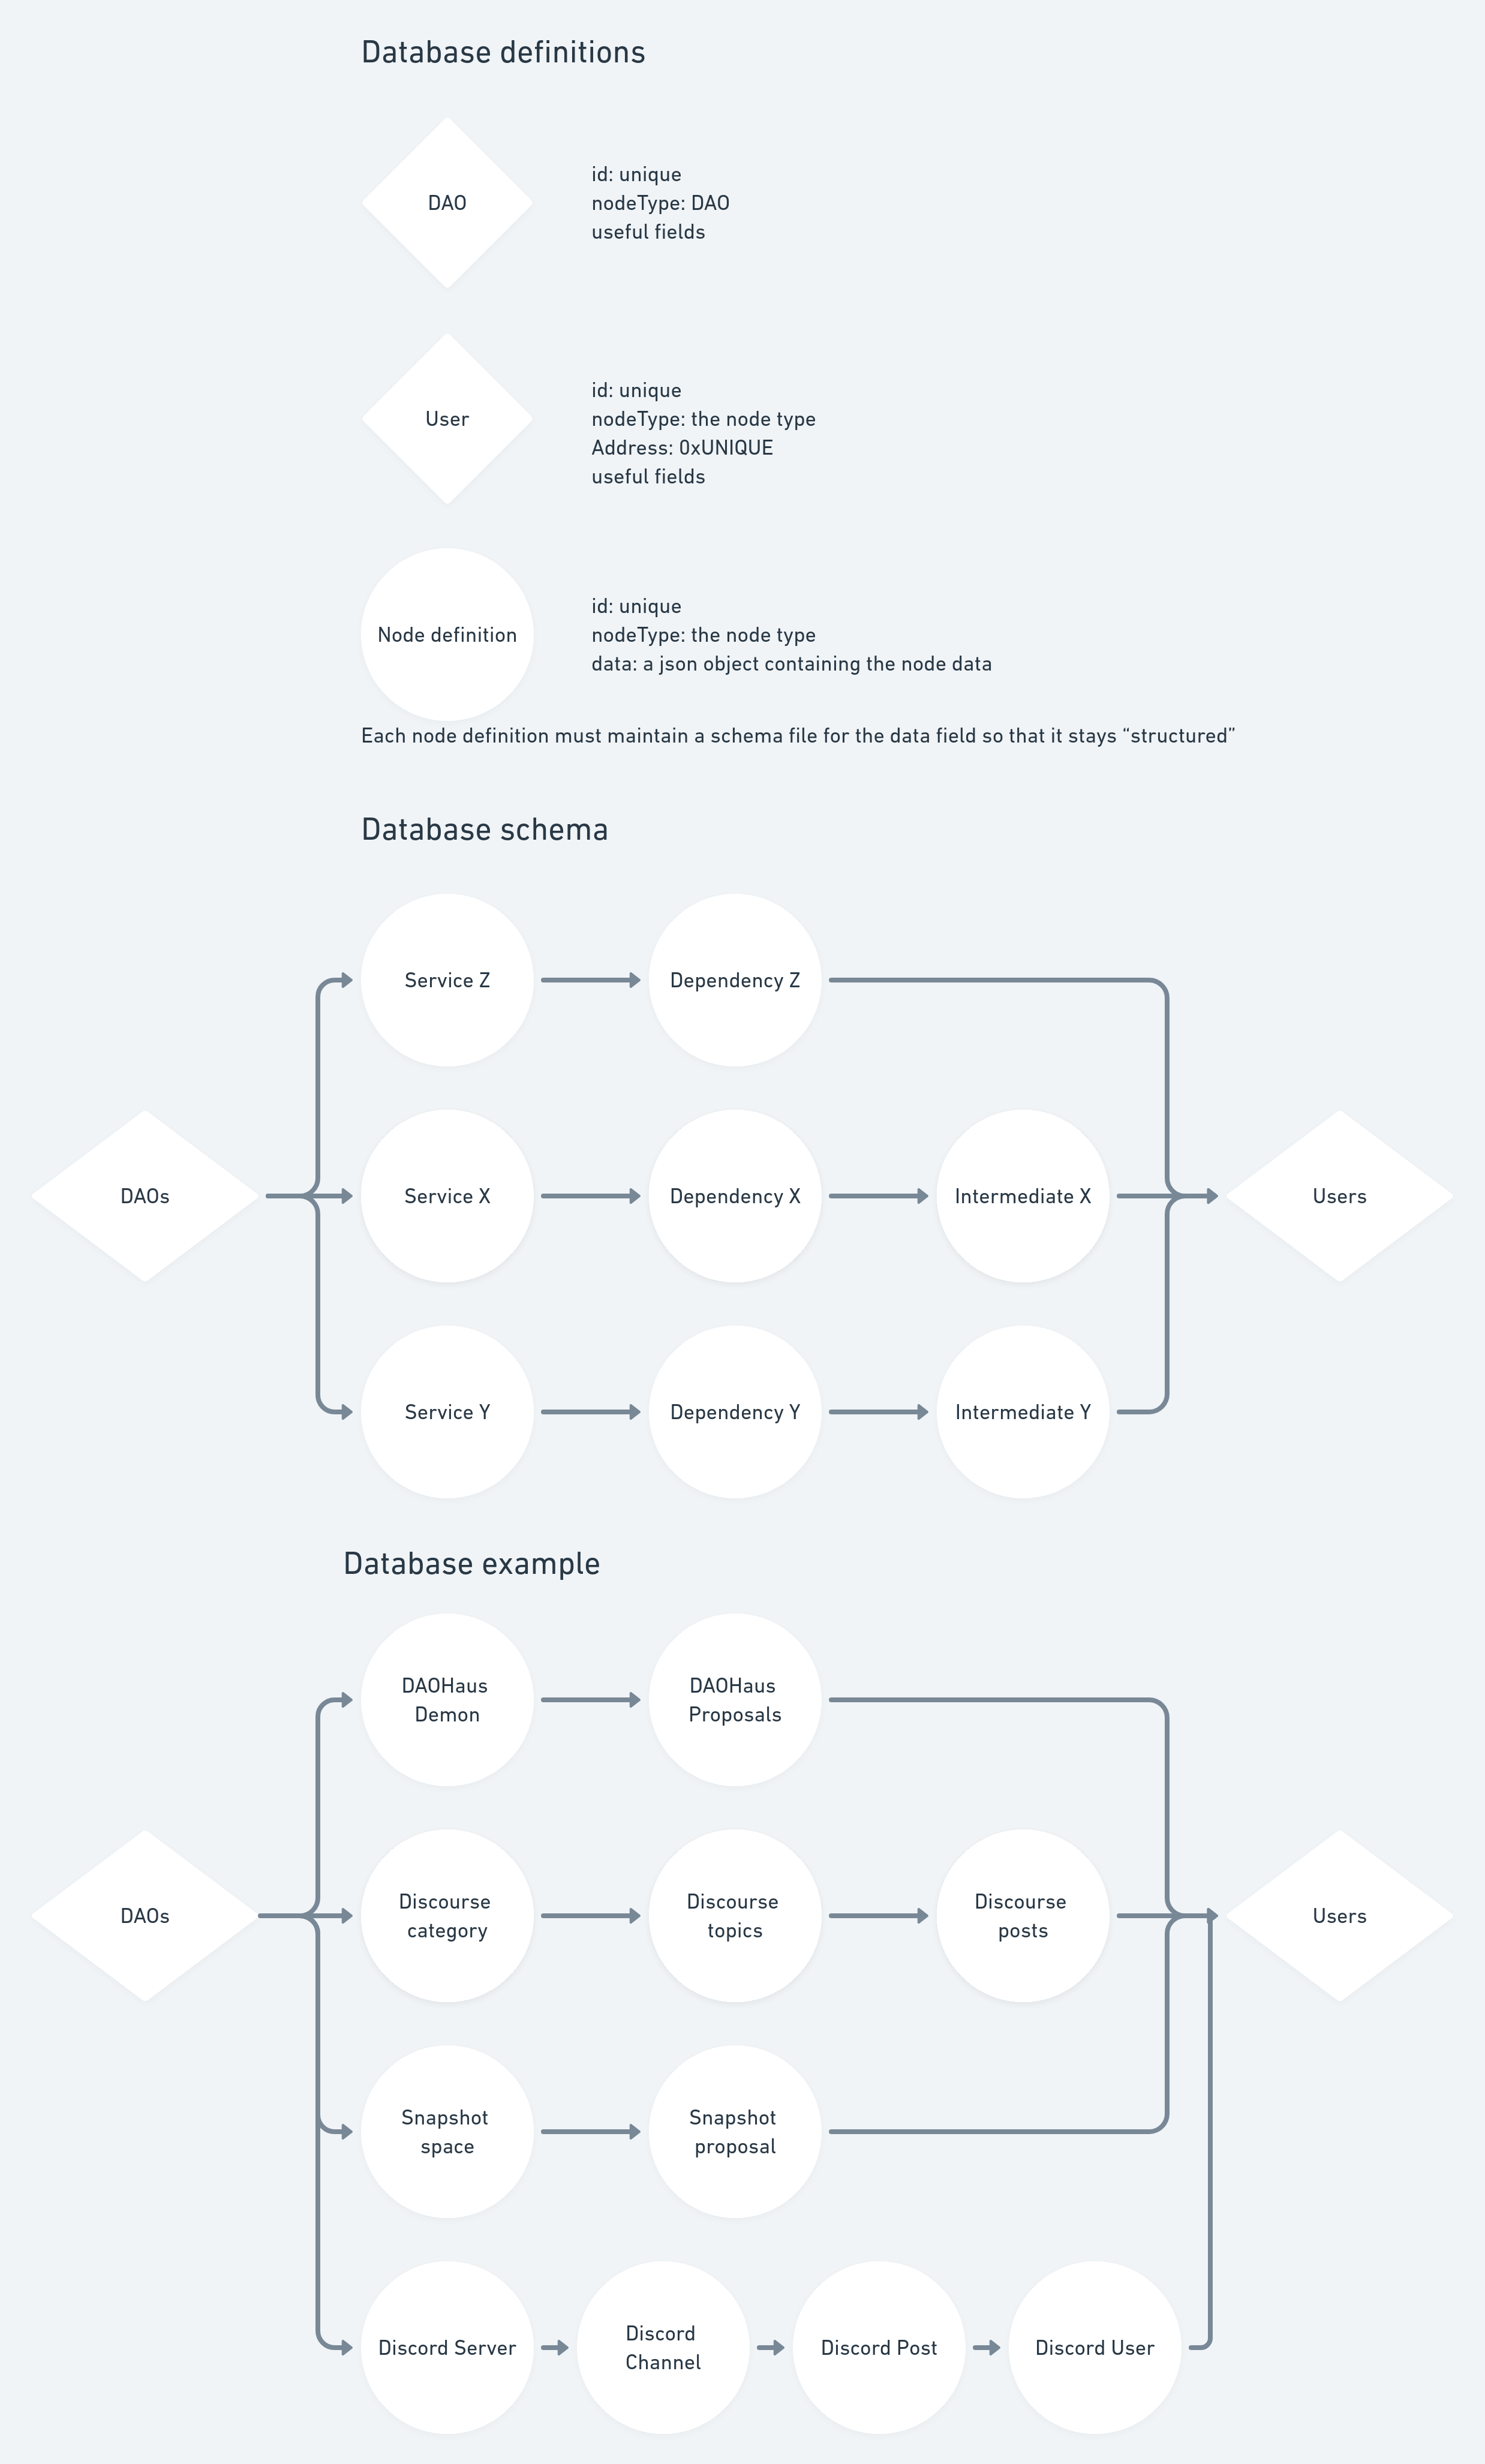

## General node types
Each node in the Neo4J database has a node Type. This is essential to sort through the different elements in the database. It is similar to a SQL table and a Mongo Collection, but is neither really.
Here is the definition of the node types that do not depend on the source of data
### Wallet
This is a wallet object, it is a very simple node, yet essential as it allows to connect between a user and actions on chain. 
```
Wallet
{
  address: string // The address of the wallet
}
```

### DAO 
This is a DAO, this object is necessary as the root of all other data. It should be created on the ChainVerse platform when someone registers a DAO, and then connected to the root of other dataspaces.
TODO: Define the fields needed for the DAO node
```
DAO
{
    name: string
}
```

In [1]:
from neo4j import GraphDatabase
from datetime import datetime

class DatabaseConnector:
    "This class defines the connector, and helper functions to interact with the chose schema"
    
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()
    
    def run_query(self, query, props=None):
        try:
            with self.driver.session() as session:
                result = session.run(query, props=props)
                return result
        except:
            print(query)
            print(props)
            raise
        
    def create_node(self, nodeType, **data):
        queryData = self._make_data_string(data)
        query = "CREATE (node:{} {}) RETURN node".format(nodeType, queryData)
        return self.run_query(query)
    
    def create_edge(self, sourceId, sourceType, targetId, targetType, edgeType, **data):
        queryData = self._make_data_string(data)
        query = """
        MATCH
          (source:{}),
          (target:{})
        WHERE source.nodeId = '{}' AND target.nodeId = '{}'
        CREATE (source)-[edge:{} {}]->(target)
        RETURN edge""".format(sourceType, targetType, sourceId, targetId, edgeType, queryData)
        return self.run_query(query)
    
    def _format_element(self, element):
        if type(element) == str:
            return '"{}"'.format(element.replace('"', "'").replace("\\", "\/"))
        elif type(element) == int:
            # This is a WTF part due to the Crypto space using insane numbers ... more than 2^63 ... seriously !!!
            if element > 1000000000000000000:
                element /= 1e12
                return '"{}t"'.format(element)
            else:
                return "toInteger({})".format(element)
        elif type(element) == float:
            return "toFloat({})".format(element)
        elif type(element) == datetime:
            return 'datetime("{}")'.format(element.isoformat())
        elif type(element) == bool:
            if element:
                return 'true'
            else:
                return 'false'
        elif type(element) == type(None):
            return 'null'
        else:
            return '"{}"'.format(element)
    
    def _make_data_string(self, data):
        if not data:
            return ""
        queryElements = []
        for key in data:
            if type(data[key]) == list:
                if len(data[key]) == 0:
                    queryElements.append('{}:[]'.format(key))
                else:
                    listType = type(data[key][0])
                    for el in data[key]:
                        assert type(el) == listType, "Neo4J only support a list of elements of the same type"
                    queryElements.append('{}:[{}]'.format(
                                                        key, 
                                                        ",".join([self._format_element(el) for el in data[key]])
                                                        )
                                        )
            else:
                # Default fall back to string
                queryElements.append('{}:{}'.format(key, self._format_element(data[key])))
        query = "{{ {} }}".format(",".join(queryElements))
        return query

In [2]:
connector = DatabaseConnector("bolt://localhost:7687", "neo4j", "diamondDAO")

## Snapshot data
It uses the snapshot data parsed with [this parser](https://github.com/DiamondDAO/shoot-your-snapshot/tree/main/SnapshotScrapper). Snapshot data has three node types and the general type Wallet:
 - SnapshotSpace
 - SnapshotStrategy
 - SnapshotProposal

### Nodes
#### SnapshotSpace
This node contains the data about a space on Snapshot
```
SnapshotSpace
{
    "spaceId": string, // Unique identifier of the space
    "symbol": string, 
    "name": string,
    "about": string,
    "filtersOnlyMembers": bool,
    "network": string,
    "filtersMinScore": float/int/string // If the number is too large it gets converted to a string with a T added at the end meaning multiply by 1e12
}
```

#### SnapshotStrategy
This node contains the data about a strategy to allow voting on snapshot. This is useful for filtering DAOs based on similar strategies. This does not yet parse well all the different strategy types, but the data is stored as a string at worst. All snapshot strategies are here https://github.com/snapshot-labs/snapshot-strategies/tree/master/src/strategies but its undocumented
```
SnapshotStrategy
{
    address: string
    decimals: int
    name: string // the name of the strategy is important as there are different types
    symbol: string
}
```

#### SnapshotProposal
This node contains the data about a proposal on a space. Voters can vote on proposals, and this is essential to understand how DAO dynamic happen.
```
SnapshotProposal
{
    proposalId: string // Unique identifier
    body: string
    votingSystem: string // The type of voting used on this proposal
    choices: array // This is important because votes will have a int value which matches the index in that array
    start: datetime
    end: datetime
    snapshot: int 
    state: string
    title: string
    votes: int
}
```
### Relations
The following relations are created during the data injestion:
 - SnapshotSpace - hasStrategy -> SnapshotStrategy
 - SnapshotProposal - isPartOf -> SnapshotSpace
 - Wallet - isAuthorOf -> SnapshotProposal
 - Wallet - isMemberOf -> SnapshotSpace
 - Wallet - isAdminOf -> SnapshotSpace
 - Wallet - hasVotedOn -> SnapshotProposal
   - choice: int / string // if int -> single choice voting this integer corresponds to the index of the SnapshotProposal.choices else its a json object
   - votedAt: datetime

In [3]:
import json
import os
from tqdm.notebook import tqdm

In [4]:
class SnapshotNeo4JConnector(DatabaseConnector):
    def __init__(self, uri, user, password):
        super().__init__(uri, user, password)
        # Here we create a few constraints so that we will error if we try to do something stupid
        self.run_query("CREATE CONSTRAINT IF NOT EXISTS ON (space:SnapshotSpace) ASSERT space.nodeId IS UNIQUE;")
        self.run_query("CREATE CONSTRAINT IF NOT EXISTS ON (wallet:Wallet) ASSERT wallet.address IS UNIQUE;")
        self.run_query("CREATE CONSTRAINT IF NOT EXISTS ON (proposal:SnapshotProposal) ASSERT proposal.proposalId IS UNIQUE;")
    
    def create_space(self, space):
        spaceData = {
            "spaceId":space["id"],
            "name":space["name"],
            "about":space["about"],
            "network":space["network"],
            "symbol":space["symbol"],
            "filtersMinScore":space["filters"]["minScore"],
            "filtersOnlyMembers":space["filters"]["onlyMembers"]
        }
        spaceQuery = self._make_data_string(spaceData)
        
        query = """
        MERGE (space:SnapshotSpace {{spaceId: {}}})
        SET space = {}
        RETURN space
        """.format(self._format_element(space['id']), spaceQuery)
        return self.run_query(query)
        
    def create_strategy(self, space, strategy):
        strategy['params']['name'] = strategy['name']
        # Need to handle a special case here for contract call type strategy
        if strategy['name'] == "contract-call":
            if "args" in strategy['params']:
                strategy['params']["args"] = "{}".format(strategy['params']["args"])
            if "methodABI" in strategy['params']:
                strategy['params']["methodABI"] = "{}".format(strategy['params']["methodABI"])
        strategyData = self._make_data_string(strategy['params'])
        # here the query use Cypher MERGE which is like a if MATCH -> bind else CREATE statement 
        query = """
            MATCH (space:SnapshotSpace {{spaceId: {}}})
            MERGE (strategy:SnapshotStrategy {})
            MERGE (space)-[edge:hasStrategy]->(strategy)
        """.format(self._format_element(space['id']), strategyData)
        return self.run_query(query)
        
    def create_proposal(self, space, proposal):
        proposalData = {
            "proposalId":proposal["id"],
            "title":proposal["title"],
            "body":proposal["body"],
            "type":proposal["votingSystem"],
            "choices":proposal["choices"],
            "start":datetime.fromtimestamp(proposal["start"]),
            "end":datetime.fromtimestamp(proposal["end"]),
            "snapshot":proposal["snapshot"], #No fucking clue what that is? Internal ID ??
            "state":proposal["state"],
            "votes":proposal["votes"],
        }
        proposalQuery = self._make_data_string(proposalData)
        
        query = """
            MATCH (space:SnapshotSpace {{spaceId: {}}})
            MERGE (proposal:SnapshotProposal {{proposalId: {}}})
            SET proposal = {}
            MERGE (author:Wallet {{address: {}}})
            MERGE (proposal)-[belongs:isPartOf]->(space)
            MERGE (author)-[authorship:isAuthorOf]->(proposal)
            RETURN proposal""".format(
                                      self._format_element(space['id']),
                                      self._format_element(proposal['id']),
                                      proposalQuery,
                                      self._format_element(proposal["author"])
                                     )
        return self.run_query(query)
        
    def create_member(self, space, member):
        query = """
            MATCH (space:SnapshotSpace {{spaceId: {}}})
            MERGE (wallet:Wallet {{address: {}}})
            MERGE (wallet)-[edge:isMemberOf]->(space)
            RETURN wallet""".format(self._format_element(space["id"]), self._format_element(member))
        return self.run_query(query)
    
    def create_admin(self, space, admin):
        query = """
            MATCH (space:SnapshotSpace {{spaceId: {}}})
            MERGE (wallet:Wallet {{address: {}}})
            MERGE (wallet)-[edge:isAdminOf]->(space)
            RETURN wallet""".format(self._format_element(space["id"]), self._format_element(admin))
        return self.run_query(query)
    
    def create_votes(self, proposal):
        props = []
        for vote in proposal["votes_data"]:
            props.append(
                { 
                    "voter": vote["id"],
                    "created": datetime.fromtimestamp(vote["created"]),
                    "choice": self._format_element(vote["choice"])
                }
            )
                
        query = """
            UNWIND $props AS data
            MATCH (proposal:SnapshotProposal {{proposalId: {}}})
            MERGE (voter:Wallet {{address: data.voter}})
            MERGE (voter)-[vote:hasVotedOn {{choice: data.choice, votedAt: data.created}}]->(proposal)
            RETURN vote""".format(self._format_element(proposal['id']))
        self.run_query(query, props)

In [440]:
connector = SnapshotNeo4JConnector("bolt://localhost:7687", "neo4j", "diamondDAO")

In [441]:
pathToData = "../daoperso/SnapshotScrapper/test2/results/"

In [442]:
with open(os.path.join(pathToData, "spaces.json")) as f:
    spaces = json.load(f)

In [443]:
for space in tqdm(spaces[1632:]):
    connector.create_space(space)
    # I'm not going to handle plugins here, because I'm not sure it has any added value at the moment...
    for strategy in space["strategies"]:
        connector.create_strategy(space, strategy)
    for member in space["members"]:
        connector.create_member(space, member)
    for admin in space["admins"]:
        connector.create_admin(space, member)
        
    spacePath = os.path.join(pathToData, "spaces", space["id"])
    proposals = os.listdir(spacePath)
    for proposalPath in proposals:
        with open(os.path.join(spacePath, proposalPath)) as f:
            proposal = json.load(f)
        connector.create_proposal(space, proposal)
        connector.create_votes(proposal)

  0%|          | 0/1858 [00:00<?, ?it/s]

## DAOHaus Discourse data
I will also use the data I extracted from the parser I made previously

In [5]:
class DiscourseNeo4JConnector(DatabaseConnector):
    def __init__(self, uri, user, password):
        super().__init__(uri, user, password)
        # Here we create a few constraints so that we will error if we try to do something stupid
        self.run_query("CREATE CONSTRAINT IF NOT EXISTS ON (space:SnapshotSpace) ASSERT space.nodeId IS UNIQUE;")
        self.run_query("CREATE CONSTRAINT IF NOT EXISTS ON (wallet:Wallet) ASSERT wallet.address IS UNIQUE;")
        self.run_query("CREATE CONSTRAINT IF NOT EXISTS ON (proposal:SnapshotProposal) ASSERT proposal.proposalId IS UNIQUE;")
    
    def create_category(self, category):
        category['categoryId'] = category['id']
        del category['id']

        categoryData = self._make_data_string(category)
        
        query = """
            MERGE (category:DiscourseCategory {{categoryId: {}}})
            SET category = {}
            RETURN category
            """.format(self._format_element(category['categoryId']), categoryData)
        return self.run_query(query)
    
    def create_user(self, user):
        user['userId'] = user['id']
        del user['id']
        user['username'] = user['user']['username']
        user['name'] = user['user']['name']
        user['avatar_template'] = user['user']['avatar_template']
        user['title'] = user['user']['title']
        del user['user']
        
        userData = self._make_data_string(user)
        query = """
            MERGE (user:DiscourseUser {{userId: {}}})
            SET user = {}
            RETURN user
            """.format(self._format_element(user['userId']), userData)
        return self.run_query(query)
        
    def create_topic(self, categoryId, topic):
        topic['topicId'] = topic['id']
        del topic['id']
        topic['created_at'] = datetime.fromisoformat(topic['created_at'][:-1])
        if topic['last_posted_at']:
            topic['last_posted_at'] = datetime.fromisoformat(topic['last_posted_at'][:-1])
        if topic['bumped_at']:
            topic['bumped_at'] = datetime.fromisoformat(topic['bumped_at'][:-1])
        del topic['posters']
        
        topicData = self._make_data_string(topic)
        query = """
            MATCH (category:DiscourseCategory {{categoryId: {}}})
            MERGE (topic:DiscourseTopic {{topicId: {}}})
            SET topic = {}
            MERGE (topic) -[edge:isPartOf]-> (category)
            RETURN topic
            """.format(self._format_element(categoryId), self._format_element(topic['topicId']), topicData)
        return self.run_query(query)
        
    def create_post(self, post):
        post["postId"] = post["id"]
        del post["id"]
        topicId = post["topic_id"]
        del post["topic_id"]
        del post["topic_slug"]
        del post["yours"]
        if "link_counts" in post:
            post["link_counts"] = len(post["link_counts"])
        del post["cooked"] # IMPORTANT I am deleting the content of the post, because I see very little value in storing that data and it is hard to format for Neo4J
        if "polls" in post:
            post["hasPolls"] = True
            del post["polls"]
        authorUsername = post["username"]
        post['created_at'] = datetime.fromisoformat(post['created_at'][:-1])
        post['updated_at'] = datetime.fromisoformat(post['updated_at'][:-1])
        
        postData = self._make_data_string(post)
        query = """
            MATCH (topic:DiscourseTopic {{topicId: {}}})
            MATCH (author:DiscourseUser {{username: {}}})
            MERGE (post:DiscoursePost {{postId: {}}})
            SET post = {}
            MERGE (post) -[edge:isPartOf]-> (topic)
            MERGE (author) -[authorship:isAuthorOf]-> (post)
            RETURN post
            """.format(self._format_element(topicId), self._format_element(authorUsername), self._format_element(post["postId"]), postData)
        return self.run_query(query)

    def create_likes(self, postId, likes):
        if not likes:
            return None
        likesData = []
        for action in likes:
            likesData.append({"userId": action['id']})
        
        query = """
            UNWIND $props as data
            MATCH (post:DiscoursePost {{postId: {}}})
            MATCH (user:DiscourseUser {{userId: data.userId}})
            MERGE (user) -[edge:hasLiked]-> (post)
            RETURN edge
            """.format(self._format_element(postId))
        return self.run_query(query, likesData)

In [6]:
connector = DiscourseNeo4JConnector("bolt://localhost:7687", "neo4j", "diamondDAO")

In [7]:
pathToData = "../daoperso/DiscourseScrapper/results"

In [8]:
with open(os.path.join(pathToData, "users.json")) as f:
    users = json.load(f)

In [9]:
with open(os.path.join(pathToData, "categories.json")) as f:
    categories = json.load(f)

In [10]:
for user in tqdm(users):
    connector.create_user(user)
    
for category in tqdm(categories, position=0):
    connector.create_category(category)
    with open(os.path.join(pathToData, "categories", "{}.json".format(category['slug']))) as f:
        category_data = json.load(f)
    for topic in tqdm(category_data['topics'], position=1):
        connector.create_topic(category['categoryId'], topic)
    postsData = category_data['posts']
    for topicId in tqdm(postsData, position=1):
        for post in postsData[topicId]['post_stream']['posts']:
            connector.create_post(post)
        for postId in postsData[topicId]['likes']:
            likes = postsData[topicId]['likes'][postId]['post_action_users']
            connector.create_likes(postId, likes)

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/5436 [00:00<?, ?it/s]

  0%|          | 0/5436 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]